# Example analysis notebook

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from expyfun.io import write_hdf5, read_hdf5

## Define the regressors

In [2]:
regressors = [
    'rect',
    'ANM',
    'IC_MUA_sampled',
    'IC_MUA_sorted_sampled',
    # 'IC_bottleneck',
    # 'IC_bottleneck_chshift',
]

In [3]:
# Root directory
root_dir = '/hdd/data/ds004356/'
# Path with the correlation and coherence EEG results
eeg_path = root_dir + 'predicted_eeg_new/'
# Path with the ABR results
ABR_path = root_dir + 'results_new/'
# Path with the extracted regressors
regressor_path = root_dir + 'regressors/'

## ABR waveforms

In [4]:
# Plot the ABR waveforms of an example subject and regressor
regressor = regressors[-1]
subject = 'subject019' # 19 is 18 in the paper
# subject = 'subject012'

In [5]:
# Read the data of the rectified regressor
filename = ABR_path + subject + '_abr_response_rect.hdf5'
data = read_hdf5(filename)
abr_music_ref = data['abr_music']
abr_speech_ref = data['abr_speech']
lags = data['lags']
# Read the data for an example regressor
filename = ABR_path + subject + '_abr_response_' + regressor + '.hdf5'
data = read_hdf5(filename)
abr_music = data['abr_music']
abr_speech = data['abr_speech']

In [6]:
t_samples = 8000

# Read the ABR waveforms
abr_speech_ave_cs_ref = np.zeros(t_samples,)
abr_music_ave_cs_ref = np.zeros(t_samples,)
for ti in abr_speech.keys():
    abr_speech_ave_cs_ref += abr_speech_ref[ti]
for ti in abr_music.keys():
    abr_music_ave_cs_ref += abr_music_ref[ti]
    
abr_speech_ave_cs = np.zeros(t_samples,)
abr_music_ave_cs = np.zeros(t_samples,)
for ti in abr_speech.keys():
    abr_speech_ave_cs = abr_speech[ti]
for ti in abr_music.keys():
    abr_music_ave_cs = abr_music[ti]

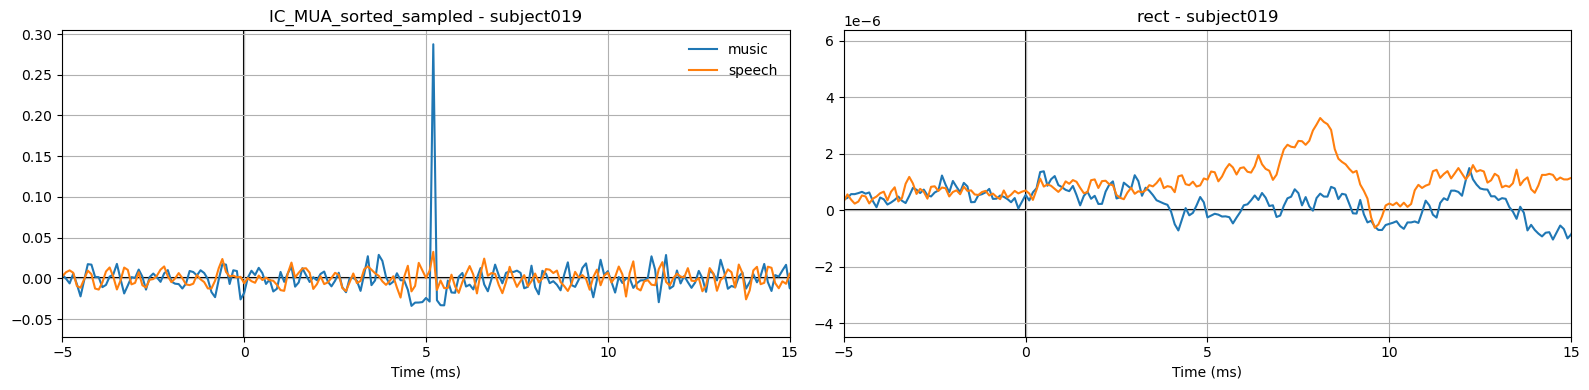

In [7]:
f, ax = plt.subplots(1,2,figsize=(16,4), sharex=True)

for axis in ax:
    axis.axhline(y=0, color='k', linestyle='-',zorder=0)
    axis.axvline(x=0, color='k', linestyle='-',zorder=0)
    axis.set_xticks(np.arange(min(lags), max(lags)+1, 5))
    axis.set_xlabel('Time (ms)')
    axis.grid();
    
ax[0].plot(lags,abr_music_ave_cs,label='music')
ax[0].plot(lags,abr_speech_ave_cs,label='speech')
ax[1].plot(lags,abr_music_ave_cs_ref)
ax[1].plot(lags,abr_speech_ave_cs_ref)

ax[0].set_title(regressor + ' - ' + subject)
ax[1].set_title('rect - ' + subject);
ax[0].legend(frameon=False)

ax[0].set_xlim(-5,15);
# ax[0].set_ylim(0.7*np.array([-1e-3,1e-3]))

f.tight_layout();

## Correlation

In [8]:
# Compute the correlations for all regressors
t_stop = 0.2 # s
music_corr = []
speech_corr = []
for i_reg, regressor in enumerate(regressors):
    # Load the results
    hdf5_file = eeg_path + regressor + '_correlation_coefficient_' + str(int(t_stop*1000)) + 'ms.hdf5'

    music_results = []
    speech_results = []
    with h5py.File(hdf5_file) as h:
        for key in h['expyfun']['key_corr_music'].keys():
            music_results.append(np.array(h['expyfun']['key_corr_music'][key][:,0])) # first column has the coefficient
        for key in h['expyfun']['key_corr_speech'].keys():
            speech_results.append(np.array(h['expyfun']['key_corr_speech'][key][:,0])) # first column has the coefficient
    # convert to numpy arrays
    music_results = np.array(music_results)
    speech_results = np.array(speech_results)
    # average the correlation across sound types
    music_corr.append(np.mean(music_results,axis=0))
    speech_corr.append(np.mean(speech_results,axis=0))

['0.0158', '0.0211', '0.0159', '0.0149']
['0.0211', '0.0238', '0.0125', '0.0154']


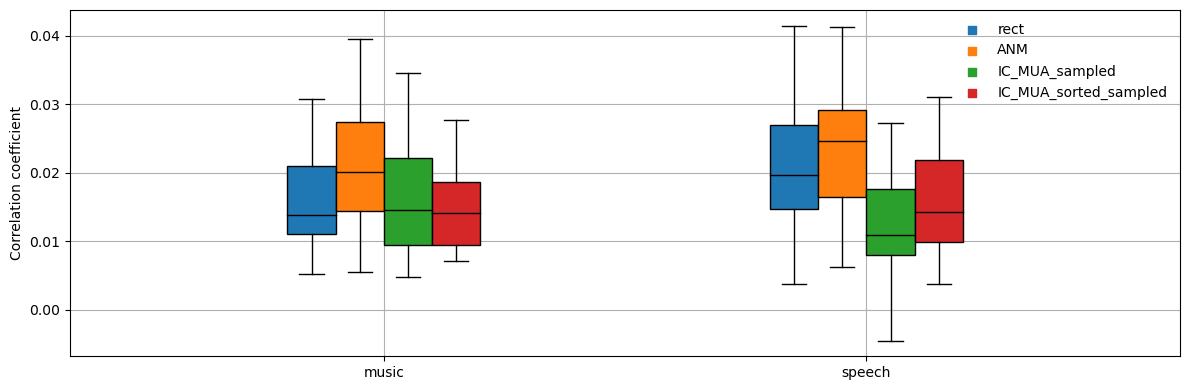

In [9]:
# Plot the correlation results
f = plt.figure(figsize=(12,4))

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
x_ticks = [0,1]
x_pos = [value - 0.05*(len(regressors)-1) for value in x_ticks]

for i_reg, regressor in enumerate(regressors):
    bplot = plt.boxplot([music_corr[i_reg],speech_corr[i_reg]], showfliers=False, positions = x_pos, widths=0.1, patch_artist=True, medianprops=dict(color='black'))
    for patch in bplot['boxes']:
        patch.set_facecolor(cycle[i_reg])
    plt.scatter([],[], marker='s', color=cycle[i_reg], label=regressor)
    x_pos = [value + 0.1 for value in x_pos]

plt.grid(zorder=0);        
plt.xticks(x_ticks,['music','speech'])
plt.legend(frameon=False)
plt.ylabel('Correlation coefficient')
f.tight_layout();
# Mean correlations
print(["%.4f" % np.mean(corr) for corr in music_corr])
print(["%.4f" % np.mean(corr) for corr in speech_corr])

## Coherence

In [10]:
# Compute the coherence for all regressors
t_stop = 0.2 # s
music_coh = []
speech_coh = []
for i_reg, regressor in enumerate(regressors):
    # Load the results
    hdf5_file = eeg_path + regressor + '_coherence_' + str(int(t_stop*1000)) + 'ms.hdf5'

    music_results = []
    speech_results = []
    with h5py.File(hdf5_file) as h:
        coh_freq = np.array(h['expyfun']['key_freq']) # coherence frequency array
        for key in h['expyfun']['key_coh_music'].keys():
            music_results.append(np.array(h['expyfun']['key_coh_music'][key]))
        for key in h['expyfun']['key_coh_speech'].keys():
            speech_results.append(np.array(h['expyfun']['key_coh_speech'][key]))
    # convert to numpy arrays and keep the absolute value
    music_results = np.array(np.abs(music_results))
    speech_results = np.array(np.abs(speech_results))
    # average the correlation across sound types and subjects
    music_coh.append(np.median(music_results,axis=(0,1)))
    speech_coh.append(np.median(speech_results,axis=(0,1)))

/tmp/ipykernel_4112481/2786017102.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  coh_freq = np.array(h['expyfun']['key_freq']) # coherence frequency array
/tmp/ipykernel_4112481/2786017102.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  music_results.append(np.array(h['expyfun']['key_coh_music'][key]))
/tmp/ipykernel_4112481/2786017102.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  speech_results.append(np.array(h['expyfun']['key_coh_speech'][key]))


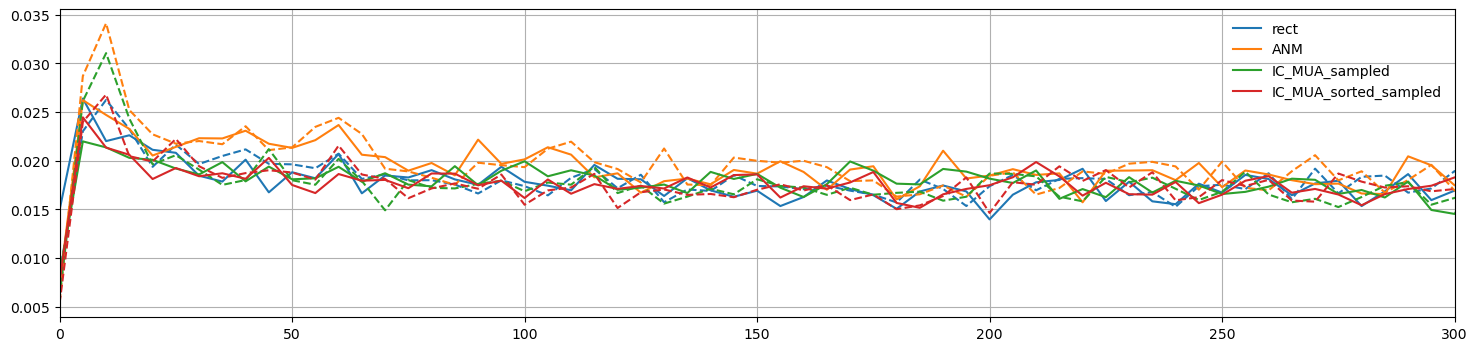

In [11]:
# Plot the coherence results
f = plt.figure(figsize=(18,4))

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i_reg, regressor in enumerate(regressors):

    plt.plot(coh_freq,speech_coh[i_reg],color=cycle[i_reg],label=regressor)
    plt.plot(coh_freq,music_coh[i_reg],color=cycle[i_reg],linestyle='--')
plt.xlim(0,300);
plt.legend(frameon=False)
plt.grid();

## Check regressors

In [12]:
def lag_finder(y1, y2, sr):
    """ Find the sample shift between y1 and y2 based on cross-correlation """
    
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]

    return int(np.round(delay*sr))-1

In [13]:
regressor_shape = (6,40,120000) # 6 types x 40 epochs x 120000 samples
regressors_music_pos = []
regressors_music_neg = []
regressors_speech_pos = []
regressors_speech_neg = []
for i_reg, regressor in enumerate(regressors):
    regressors_music_pos.append(np.zeros(regressor_shape))
    regressors_music_neg.append(np.zeros(regressor_shape))
    regressors_speech_pos.append(np.zeros(regressor_shape))
    regressors_speech_neg.append(np.zeros(regressor_shape))
    h = h5py.File(regressor_path + regressor + '/speech_x_in.hdf5')
    for i_key, key in enumerate(h['expyfun']['key_x_in_speech_pos'].keys()):
        regressors_speech_pos[i_reg][i_key] = h['expyfun']['key_x_in_speech_pos'][key]
        regressors_speech_neg[i_reg][i_key] = h['expyfun']['key_x_in_speech_neg'][key]
    h.close()
    h = h5py.File(regressor_path + regressor + '/music_x_in.hdf5')
    for i_key, key in enumerate(h['expyfun']['key_x_in_music_pos'].keys()):
        regressors_music_pos[i_reg][i_key] = h['expyfun']['key_x_in_music_pos'][key]
        regressors_music_neg[i_reg][i_key] = h['expyfun']['key_x_in_music_neg'][key]
    h.close()

/tmp/ipykernel_4112481/1169467754.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_speech_pos[i_reg][i_key] = h['expyfun']['key_x_in_speech_pos'][key]
/tmp/ipykernel_4112481/1169467754.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_speech_neg[i_reg][i_key] = h['expyfun']['key_x_in_speech_neg'][key]
/tmp/ipykernel_4112481/1169467754.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_music_pos[i_reg][i_key] = h['expyfun']['key_x_in_music_pos'][key]
/tmp/ipykernel_4112481/1169467754.py:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_music_neg[i_reg][i_key] = h['expyfun']['key_x_in_music_neg'][key]


delay to rect: 29
delay to rect: 26
delay to rect: -39


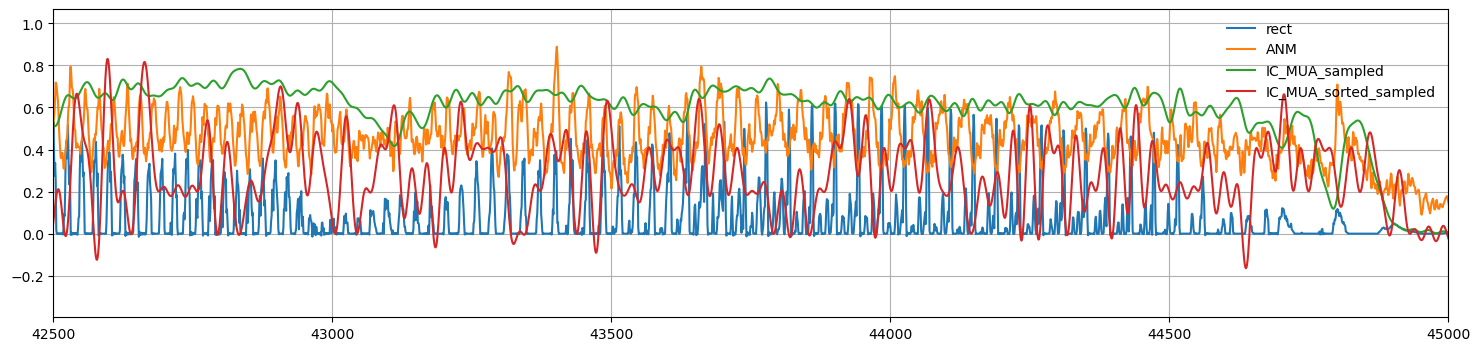

In [36]:
# Plot the regressors for an example speech segment
i_type = 1
i_epoch = 25

f = plt.figure(figsize=(18,4))

for i_reg, regressor in enumerate(regressors):
    normalised_regressor = regressors_speech_pos[i_reg][i_type][i_epoch]/np.max(regressors_speech_pos[i_reg][i_type][i_epoch])
    plt.plot(normalised_regressor,label=regressor)
    if i_reg > 0:
        delay = lag_finder(regressors_speech_pos[0][i_type][i_epoch],normalised_regressor,10e3)
        print('delay to rect:',delay)

plt.legend(frameon=False)
plt.grid();

plt.xlim(42500,45000);

#### Click

In [28]:
# Get the regressor for click responses (if any)
regressors_click_pos = []
regressors_click_neg = []
for i_reg, regressor in enumerate(regressors):
    regressors_click_pos.append(np.zeros(1000))
    regressors_click_neg.append(np.zeros(1000))
    h = h5py.File(regressor_path + regressor + '/click_x_in.hdf5')
    # print(h['expyfun'].keys())
    regressors_click_pos[i_reg] = np.array(h['expyfun']['key_x_in_click_pos'])[0]
    regressors_click_neg[i_reg] = np.array(h['expyfun']['key_x_in_click_neg'])[0]
    h.close()

/tmp/ipykernel_4112481/2733597207.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_click_pos[i_reg] = np.array(h['expyfun']['key_x_in_click_pos'])[0]
/tmp/ipykernel_4112481/2733597207.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  regressors_click_neg[i_reg] = np.array(h['expyfun']['key_x_in_click_neg'])[0]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/hdd/data/ds004356/regressors/IC_MUA_sorted_sampled/click_x_in.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

delay to rect: 27
delay to rect: 54
delay to rect: -101


/tmp/ipykernel_4112481/1852306656.py:5: RuntimeWarning: invalid value encountered in divide
  normalised_regressor = regressors_click_pos[i_reg]/np.max(regressors_click_pos[i_reg])


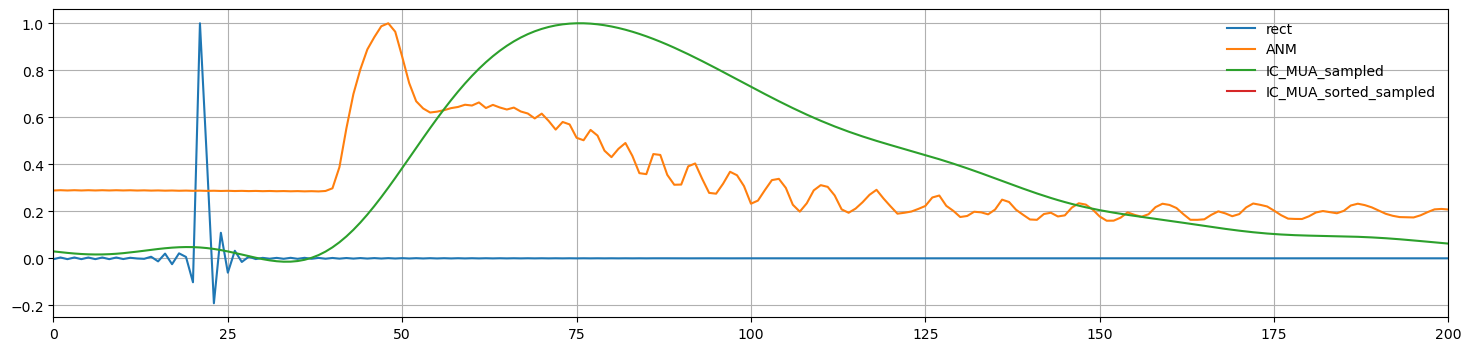

In [35]:
# Plot the regressors for a click stimulus
f = plt.figure(figsize=(18,4))

for i_reg, regressor in enumerate(regressors):
    normalised_regressor = regressors_click_pos[i_reg]/np.max(regressors_click_pos[i_reg])
    plt.plot(normalised_regressor,label=regressor)
    if i_reg > 0:
        delay = lag_finder(regressors_click_pos[0][:200],normalised_regressor[:200],10e3)
        print('delay to rect:',delay)

plt.legend(frameon=False)
plt.grid();

plt.xlim(0,200);